# Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
# from aeon.datasets import load_classification

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, Dataset
from torchvision import datasets, transforms
from torchvision.models.resnet import Bottleneck, BasicBlock, conv1x1

# import lightning as L

import sklearn
from sklearn.model_selection import train_test_split

In [2]:
from ContrastiveClustering import ContrastiveCluster as CC
import ClusterEval

In [3]:
SEED = 69
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

# Load Benchmark Data

## Share Price Increase

The problem here is to predict whether a share price will show an exceptional rise after quarterly announcement of the Earning Per Share based on the price movement of that share price on the proceeding 60 days? The data was formatted by Vlad Pazenuks as part of his third year project. Daily price data on NASDAQ 100 companies was extracted from a Kaggle data set. Reporting dates of these companies were obtained from NASDAQ.com. Each data is the percentage change of the close price from the day before. Each case is a series of 60 day data. The target class is is defined as 0 = price did not increase after company report release by more than 5 percent 1 = price increased after company report release by more than 5 percent There are 1931 cases, 1326 class 0 and 605 class 1.

In [ ]:
share_price_increase = load_classification('SharePriceIncrease')

In [ ]:
print(len(share_price_increase))
share_data, share_labels = share_price_increase
# share_labels = share_labels.astype('int')
# share_data = torch.tensor(share_data)
# share_labels = torch.tensor(share_labels)

2


In [ ]:
share_labels

array(['0', '0', '0', ..., '1', '1', '1'], dtype='<U1')

In [ ]:
dataset = TensorDataset(share_data, share_labels)
dataloader = DataLoader(dataset)

In [ ]:
len(share_data)

1931

In [ ]:
len(share_data)

1931

In [ ]:
dataset

In [ ]:
len(share_data[0][0])

60

In [ ]:
dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

In [ ]:
share_data

array([[[-4.14537643e+00, -7.70140984e-01,  2.00994691e+00, ...,
          5.79414027e-01,  6.43851347e-01,  8.75415202e-01]],

       [[-7.49062935e-01,  9.43390794e-01, -1.86911257e-01, ...,
          0.00000000e+00, -5.01675748e-01,  2.68908117e+00]],

       [[ 4.92917295e+00,  1.06292335e+00,  7.73693641e-01, ...,
         -4.89453986e-01, -6.91255106e-01, -1.28505329e+00]],

       ...,

       [[-7.21991939e-01,  7.44954318e-02, -1.46049916e+00, ...,
         -2.89349551e+00, -1.68077088e+00,  1.56116505e-01]],

       [[-5.66930304e-01, -8.26156696e-01, -2.81597423e-01, ...,
         -9.97105542e-01,  6.17291907e-01, -5.05867186e-01]],

       [[-7.74558560e-01,  5.83855185e-01, -4.22694555e-03, ...,
          2.99329532e-01,  3.00461488e-01, -4.03839405e-03]]])

In [ ]:
share_labels

array(['0', '0', '0', ..., '1', '1', '1'], dtype='<U1')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(share_data, share_labels, test_size = 0.6, random_state = SEED)

## Fashion MNIST

In [4]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in loader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

class ContrastiveFashionMNIST(Dataset):
    def __init__(self, root, train=True, transform=None, download=True):
        self.fashion_mnist = datasets.FashionMNIST(root=root, train=train, download=download)
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.fashion_mnist[index]
        img1 = self.transform(img)
        img2 = self.transform(img)
        return (img1, img2), target

    def __len__(self):
        return len(self.fashion_mnist)

def load_fashion_mnist(batch_size, use_cuda=False):
    # First, create a DataLoader without normalization
    initial_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    initial_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=initial_transform)
    initial_loader = DataLoader(initial_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

    # Calculate mean and std
    mean, std = get_mean_std(initial_loader)
    # print(f"Calculated mean: {mean.item():.4f}, std: {std.item():.4f}")

    # Now create the full transform with the calculated mean and std
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((mean.item(),), (std.item(),))
    ])

    train_dataset = ContrastiveFashionMNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = ContrastiveFashionMNIST(root='./data', train=False, transform=transform, download=True)
    full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

    kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
    data_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

    return data_loader

def load_fashion_mnist_test(batch_size, use_cuda=False):
    initial_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    initial_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=initial_transform)
    initial_loader = DataLoader(initial_dataset, batch_size=batch_size, num_workers=2, shuffle=False)
    mean, std = get_mean_std(initial_loader)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean.item(),), (std.item(),))
    ])
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)
    return test_loader



## Heterogeneity Human Activity Recognition (HHAR)

# Models

In [5]:
import os

def save_model(model, optimizer, epoch, loss, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    filename = f'checkpoint_epoch_{epoch}.pth'
    save_path = os.path.join(save_dir, filename)
    torch.save(state, save_path)
    print(f"Model saved to {save_path}")


def load_model(model, optimizer, load_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(load_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Model loaded from epoch {epoch} with loss {loss:.4f}")
    return epoch, loss


## Contrastive Clustering

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available(): print('Using GPU')

# Hyperparameters
batch_size = 512
feature_dim = 256
class_num = 10
learning_rate = 0.002
num_epochs = 1_000
instance_temperature = 0.5
cluster_temperature = 1.0
save_interval = 50
eval_interval = 50
save_dir = './cc_checkpoints'  # Directory to save model checkpoints

# Create backbone network
backbone = CC.ResNetFashionMNIST(block=CC.BasicBlock, layers=[2, 2, 2, 2])  # ResNet18

model = CC.ContrastiveClusteringNetwork(backbone, feature_dim, class_num).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Using GPU


In [ ]:
# Load the model if a checkpoint exists
load_path = './cc_checkpoints/checkpoint_epoch_100.pth'  # Adjust this path as needed
if os.path.exists(load_path):
    start_epoch, last_loss = load_model(model, optimizer, load_path)
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0
    print("Starting training from scratch")

criterion_instance = CC.InstanceLoss(batch_size, instance_temperature, device).to(device)
criterion_cluster = CC.ClusterLoss(class_num, cluster_temperature, device).to(device)

# Load Fashion-MNIST dataset
data_loader = load_fashion_mnist(batch_size, use_cuda=torch.cuda.is_available())

# Prepare for monitoring
train_losses = []
nmi_scores = []
ari_scores = []
acc_scores = []
eval_epochs = []

# Load test data for evaluation
test_loader = load_fashion_mnist_test(batch_size, use_cuda=torch.cuda.is_available())

# Training loop
for epoch in range(start_epoch, num_epochs):
    loss = CC.train(model, data_loader, optimizer, criterion_instance, criterion_cluster, device)
    train_losses.append(loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")
    
    # Save model at regular intervals
    if (epoch + 1) % save_interval == 0:
        save_model(model, optimizer, epoch + 1, loss, save_dir)
    
    if (epoch + 1) % eval_interval == 0:
        # Evaluate the model
        predictions, true_labels = ClusterEval.evaluate(model, test_loader, device)
        nmi, ari, acc = ClusterEval.compute_metrics(true_labels, predictions)
        nmi_scores.append(nmi)
        ari_scores.append(ari)
        acc_scores.append(acc)
        eval_epochs.append(epoch + 1)
        print(f"NMI: {nmi:.4f}, ARI: {ari:.4f}, Accuracy: {acc:.4f}")

# Save final model
save_model(model, optimizer, num_epochs, loss, save_dir)

# Final evaluation
predictions, true_labels = ClusterEval.evaluate(model, test_loader, device)
nmi, ari, acc = ClusterEval.compute_metrics(true_labels, predictions)
print(f"Final Results - NMI: {nmi:.4f}, ARI: {ari:.4f}, Accuracy: {acc:.4f}")

# Plot final results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(start_epoch + 1, num_epochs + 1), train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(eval_epochs, nmi_scores, label='NMI')
plt.plot(eval_epochs, ari_scores, label='ARI')
plt.title('Clustering Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(eval_epochs, acc_scores)
plt.title('Clustering Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.savefig(f'{save_dir}/final_training_progress.png')
plt.close()

/tmp/ipykernel_3546597/3539740119.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, map_location=device)


Model loaded from epoch 100 with loss 7.0160
Resuming training from epoch 100
Epoch [101/1000], Loss: 7.0161


In [ ]:
print('hello')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available(): print('Using GPU')

# Hyperparameters
batch_size = 512
feature_dim = 128
class_num = 10
learning_rate = 0.002
num_epochs = 100
instance_temperature = 0.5
cluster_temperature = 1.0

# Create backbone network
backbone = CC.ResNetFashionMNIST(block=CC.BasicBlock, layers=[2, 2, 2, 2])  # ResNet18

model = CC.ContrastiveClusteringNetwork(backbone, feature_dim, class_num).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

load_path = './drive/MyDrive/FYP/CC_checkpoints/checkpoint_epoch_100.pth'  # Adjust this path as needed
if os.path.exists(load_path):
    start_epoch, last_loss = load_model(model, optimizer, load_path)

Using GPU
Model loaded from epoch 100 with loss 6.3176


Evaluating the model...
Clustering Results:
NMI: 0.3257
ARI: 0.2086
Accuracy: 0.3926
Generating visualization...


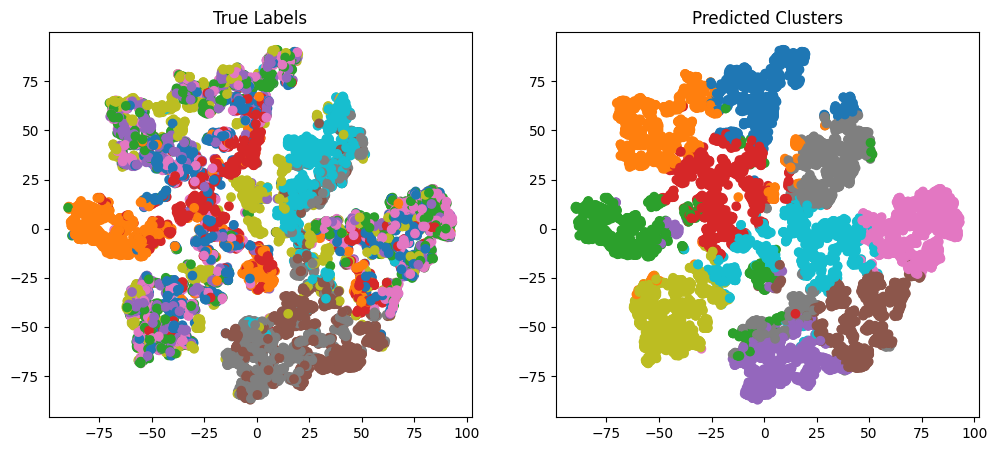

In [ ]:
# Evaluation
print("Evaluating the model...")

# Load test dataset
test_loader = load_fashion_mnist_test(batch_size, use_cuda=torch.cuda.is_available())

# Perform evaluation
predictions, true_labels = ClusterEval.evaluate(model, test_loader, device)
nmi, ari, acc = ClusterEval.compute_metrics(true_labels, predictions)

print(f"Clustering Results:")
print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")
print(f"Accuracy: {acc:.4f}")

# Visualize results (optional)
print("Generating visualization...")
features = []
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        feat = model.backbone(images)
        features.extend(feat.cpu().numpy())

features = np.array(features)
ClusterEval.visualize_clusters(features, true_labels, predictions)

## Twin Contrastive Learning

## Structural Deep Clustering Network